In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras
%matplotlib inline

Using TensorFlow backend.


In [0]:
from math import ceil
import numpy as np

def img_combine(img, ncols = 8, size = 1):
  n_img = len(img)
  nrows = ceil(int(n_img / 8))
  fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, sharey = True, figsize = (ncols * size, nrows * size))
  if nrows ==0:
    return
  
  for row in range(nrows):
    for col in range(ncols):
      nth = row * ncols + col
      ax = axes[row,col]
      if nth < n_img:
          ax.imshow(img[nth], cmap = 'rainbow', vmin = 0, vmax = 1)
          ax.set_axis_off()
      else:
        row = nrows
        break
  
  
  plt.show()

In [0]:
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

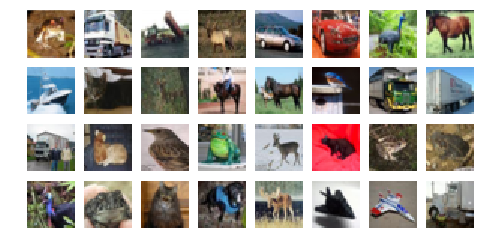

In [8]:
imgs = train_x[:32]
img_combine(imgs)

In [0]:
data_aug = ImageDataGenerator(
                  rotation_range = 20,
                  width_shift_range = 0.2,
                  height_shift_range = 0.2,
                  horizontal_flip = True)

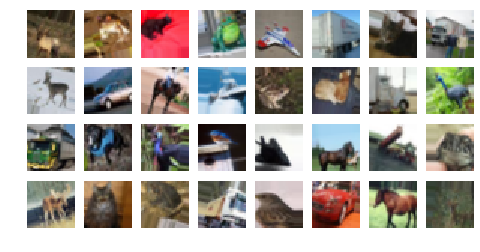

In [10]:
aug_img = next(data_aug.flow(imgs, shuffle = True))
img_combine(aug_img.astype('int'))

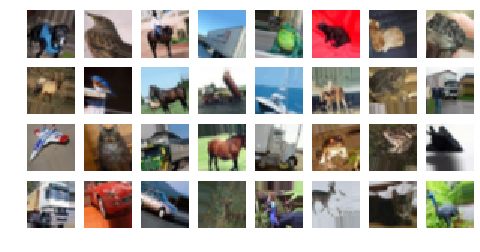

In [11]:
aug_img = next(data_aug.flow(imgs, shuffle = True))
img_combine(aug_img.astype('int'))

# 作業
請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [0]:
def cn_bn_act(x, filters = 32, kernel_size = (3,3), strides = (1,1), padding = 'same', layers = 1):
  
  for i in range(layers):
      x = keras.layers.Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding)(x)
      x = keras.layers.BatchNormalization()(x)
      x = keras.layers.Activation('relu')(x)
  return x

In [0]:
def build_vgg16(input_shape, output_units = 10):
  
  input_layer = keras.layers.Input(input_shape)
  x = keras.layers.BatchNormalization()(input_layer)
  x = cn_bn_act(x = x, filters = 64, kernel_size = (3,3), padding = 'same',layers = 1)
  x = cn_bn_act(x = x, filters = 64, kernel_size = (3,3), padding = 'same', layers = 1)
  x = keras.layers.MaxPooling2D(pool_size = (2,2))(x)
  x = keras.layers.Dropout(0.5)(x)
  x = cn_bn_act(x = x, filters = 128, kernel_size = (3,3), padding = 'same', layers = 2)
  x = keras.layers.MaxPooling2D(pool_size = (2,2))(x)
  x = keras.layers.Dropout(0.5)(x)  
  x = cn_bn_act(x = x, filters = 256, kernel_size = (3,3), padding = 'same', layers = 3)
  x = keras.layers.MaxPooling2D(pool_size = (2,2))(x)
  x = keras.layers.Dropout(0.5)(x)  
  x = cn_bn_act(x = x, filters = 512, kernel_size = (3,3), padding = 'same', layers = 3)
  x = keras.layers.MaxPooling2D(pool_size = (2,2))(x)
  x = keras.layers.Dropout(0.5)(x)  
  x = cn_bn_act(x = x, filters = 512, kernel_size = (3,3), padding = 'same', layers = 3)
  x = keras.layers.MaxPooling2D(pool_size = (2,2))(x)
  x = keras.layers.Dropout(0.5)(x)  
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(units = 512)(x)
  x = keras.layers.BatchNormalization()(x)
  output_layer = keras.layers.Dense(units = output_units, activation = 'softmax')(x)
  
  model = keras.models.Model(inputs = [input_layer], outputs = output_layer)
  return model

In [0]:
data_aug = ImageDataGenerator(
                  rotation_range = 20,
                  width_shift_range = 0.2,
                  height_shift_range = 0.2,
                  horizontal_flip = True)

In [20]:
data_aug.fit(train_x)
vgg16 = build_vgg16(train_x.shape[1:])
vgg16.summary()

W0805 13:13:58.351932 140532372002688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 64)        256       
__________

In [21]:
batch_size = 128
epochs = 20
lr = 1e-3

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patiene = 4, min_lr = 1e-5, mode = 'min')
es = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6, mode = 'min')

vgg16.compile(optimizer = keras.optimizers.Adam(lr = lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])

W0805 13:17:46.507868 140532372002688 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
train_y = keras.utils.to_categorical(train_y, 10)
test_y = keras.utils.to_categorical(test_y, 10)

In [24]:
history = vgg16.fit_generator(data_aug.flow(train_x, train_y, batch_size = batch_size), epochs = epochs, verbose = 1, validation_data = (test_x, test_y), steps_per_epoch = train_x.shape[0]/batch_size,
                             callbacks = [es, reduce_lr])

Epoch 1/20
391/390 [==============================] - 44s 113ms/step - loss: 2.0385 - acc: 0.2254 - val_loss: 2.2799 - val_acc: 0.2236
Epoch 2/20
391/390 [==============================] - 34s 88ms/step - loss: 1.6393 - acc: 0.3782 - val_loss: 1.8668 - val_acc: 0.4209
Epoch 3/20
391/390 [==============================] - 34s 87ms/step - loss: 1.4028 - acc: 0.4868 - val_loss: 1.6907 - val_acc: 0.5194
Epoch 4/20
391/390 [==============================] - 34s 87ms/step - loss: 1.2495 - acc: 0.5544 - val_loss: 1.7170 - val_acc: 0.5581
Epoch 5/20
391/390 [==============================] - 34s 87ms/step - loss: 1.1273 - acc: 0.6023 - val_loss: 1.7375 - val_acc: 0.5432
Epoch 6/20
391/390 [==============================] - 34s 87ms/step - loss: 1.0480 - acc: 0.6329 - val_loss: 1.2588 - val_acc: 0.6070
Epoch 7/20
391/390 [==============================] - 34s 87ms/step - loss: 0.9731 - acc: 0.6615 - val_loss: 1.0549 - val_acc: 0.6664
Epoch 8/20
391/390 [==============================] - 34s 87m

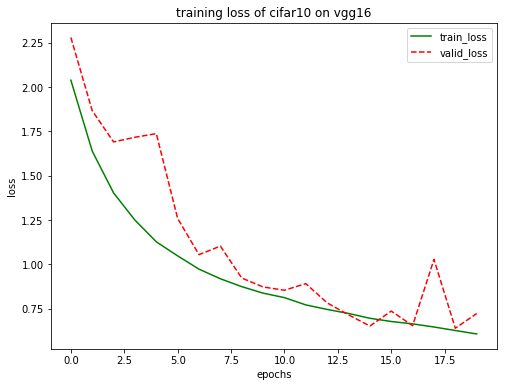

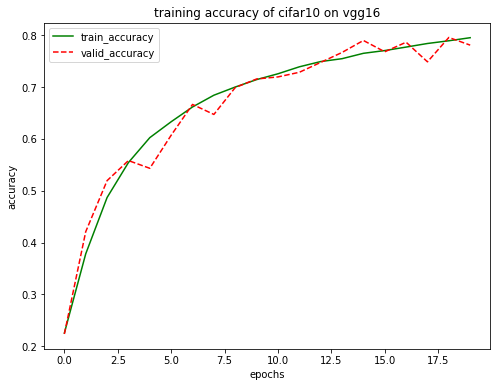

In [25]:
plt.figure(figsize = (8,6))
plt.plot(history.history['loss'], '-', label = 'train_loss', color = 'g')
plt.plot(history.history['val_loss'], '--', label = 'valid_loss', color = 'r')
plt.title('training loss of cifar10 on vgg16')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure(figsize = (8,6))
plt.plot(history.history['acc'], '-', label = 'train_accuracy', color = 'g')
plt.plot(history.history['val_acc'], '--', label = 'valid_accuracy', color = 'r')
plt.title('training accuracy of cifar10 on vgg16')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()